<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Softmax Regression ,One-vs-All & One-vs-One for Multi-class Classification**


Estimated time needed: **1** hour


In this lab, we will study how to convert a linear classifier into a multi-class classifier, including multinomial logistic regression or softmax regression, One vs. All (One-vs-Rest) and One vs. One


## **Objectives**


After completing this lab you will be able to:


*   Understand and apply some theory behind:
    *   Softmax regression
    *   One vs. All (One-vs-Rest)
    *   One vs. One


## **Introduction**


In Multi-class classification, we classify data into multiple class labels . Unlike classification trees and k-nearest neighbour, the concept of  Multi-class classification for linear classifiers is not as straightforward. We can convert logistic regression to Multi-class classification using multinomial logistic regression or softmax regression; this is a generalization of logistic regression, this will not work for support vector machines. One vs. All (One-vs-Rest) and One vs. One are two other multi-class classification techniques can covert any two-class classifier to a multi-class classifier.


***


## **Install and Import the required libraries**


For this lab, we are going to be using several Python libraries such as scit-learn, numpy and matplotlib  for visualizations. Some of these libraries might be installed in your lab environment, others may need to be installed by you by removing the hash signs. The cells below will install these libraries when executed.


In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])


In [2]:

from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Utility Function


This functions Plots different decision boundary


In [4]:
plot_colors = "ryb"
plot_step = 0.02

def decision_boundary (X,y,model,iris, two=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z,cmap=plt.cm.RdYlBu)
    
    if two:
        cs = plt.contourf(xx, yy, Z,cmap=plt.cm.RdYlBu)
        for i, color in zip(np.unique(y), plot_colors):
            
            idx = np.where( y== i)
            plt.scatter(X[idx, 0], X[idx, 1], label=y,cmap=plt.cm.RdYlBu, s=15)
        plt.show()
  
    else:
        set_={0,1,2}
        print(set_)
        for i, color in zip(range(3), plot_colors):
            idx = np.where( y== i)
            if np.any(idx):

                set_.remove(i)

                plt.scatter(X[idx, 0], X[idx, 1], label=y,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)


        for  i in set_:
            idx = np.where( iris.target== i)
            plt.scatter(X[idx, 0], X[idx, 1], marker='x',color='black')

        plt.show()


This function will plot the probability of belonging to each class; each column is the probability of belonging to a class the row number is the sample number.


In [5]:
def plot_probability_array(X,probability_array):

    plot_array=np.zeros((X.shape[0],30))
    col_start=0
    ones=np.ones((X.shape[0],30))
    for class_,col_end in enumerate([10,20,30]):
        plot_array[:,col_start:col_end]= np.repeat(probability_array[:,class_].reshape(-1,1), 10,axis=1)
        col_start=col_end
    plt.imshow(plot_array)
    plt.xticks([])
    plt.ylabel("samples")
    plt.xlabel("probability of 3 classes")
    plt.colorbar()
    plt.show()

In ths lab we will use the  iris dataset,  it consists of 3 different types of irises’ (Setosa y=0, Versicolour y=1, and Virginica y=2) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

The below plot uses the secoond two features


In [6]:
pair=[1, 3]
iris = datasets.load_iris()
X = iris.data[:, pair]
y = iris.target
np.unique(y)

array([0, 1, 2])

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("sepal width (cm)")
plt.ylabel("petal width")

Text(0, 0.5, 'petal width')

## **Softmax Regression**


SoftMax regression is similar to logistic regression, the softmax function  convernts the actual distances i.e. dot products of $x$ with each of the parameters $\theta_i$ for the $K$ classes. This is converted to probabilities using the following :


$softmax(x,i) = \frac{e^{ \theta_i^T \bf x}}{\sum\_{j=1}^K e^{\theta_j^T x}} $


The training procedure is almost identical to logistic regression. Consider the three-class example where $y \in {0,1,2}$ we would like to classify $x\_1$. We can use the softmax function to generate a probability of how likely the sample belongs to each class:


$\[softmax(x\_1,0),softmax(x\_1,1),softmax(x\_1,2)]=\[0.97,0.2,0.1]$


The index of each probability is the same as the class. We can make a prediction using the argmax function:


$\hat{y}=argmax_i  {softmax(x,i)}$


For the above example, we can make a prediction as follows:


$\hat{y}=argmax_i  {\[0.97,0.2,0.1]}=0$


<code>sklearn</code> does this automatically, but we can verify the prediction step, we fit the model:


In [8]:
lr = LogisticRegression(random_state=0).fit(X, y)

We generate the probability using the method <ocde>predict_proba</code>


In [9]:
probability=lr.predict_proba(X)


We can plot the probability of belonging to each class; each column is the probability of belonging to a class the row number is the sample number.


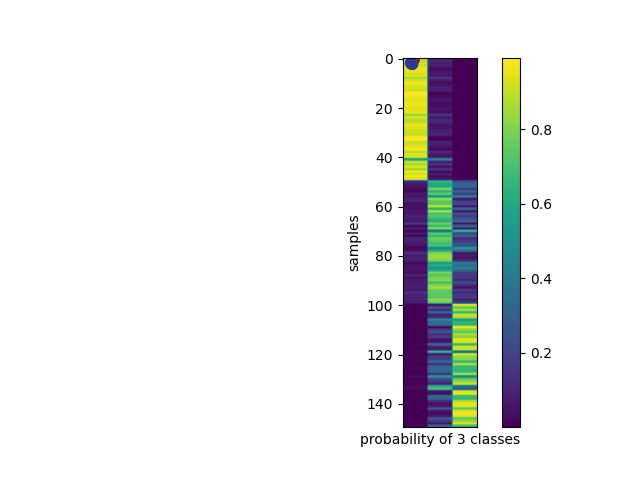

In [10]:
plot_probability_array(X,probability)

Here is the output for the first sample:


In [11]:
probability[0,:]

array([9.57671606e-01, 4.22321095e-02, 9.62845517e-05])

we see it sums to one


In [12]:
probability[0,:].sum()

1.0

we can apply the $argmax$ function


In [13]:
np.argmax(probability[0,:])

0

We can apply the $argmax$ function to each sample


In [14]:
softmax_prediction=np.argmax(probability,axis=1)
softmax_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

We can verify that sklearn does this under the hood by comparing it to the output of the method <code> predict  </code>.


In [15]:
yhat =lr.predict(X)
accuracy_score(yhat,softmax_prediction)

1.0

We can't use Softmax regression for SVMs let explore two methods of Multi-class Classification. that we can apply to SVM.


## SVM


Sklean performs Multi-class Classification automatically, we can apply the method and calculate the accuracy. Train a SVM classifier with the `kernel` set to `linear`, `gamma` set to `0.5`, and the `probability` paramter set to `True`, then train the model using the `X` and `y` data.


In [19]:
model = SVC(kernel='linear', gamma = 0.5, probability = True)
model.fit(X, y) 
#ADD CODE

#ADD CODE


SVC(gamma=0.5, kernel='linear', probability=True)

<details><summary>Click here for the solution</summary>

```python
model = SVC(kernel='linear', gamma=.5, probability=True)

model.fit(X,y)

```

</details>


Find the `accuracy_score` on the training data


In [20]:
yhat = model.predict(X)
accuracy_score(y,yhat)

0.96

<details><summary>Click here for the solution</summary>

```python
yhat = model.predict(X)

accuracy_score(y,yhat)

```

</details>


We can plot the decision_boundary.


{0, 1, 2}


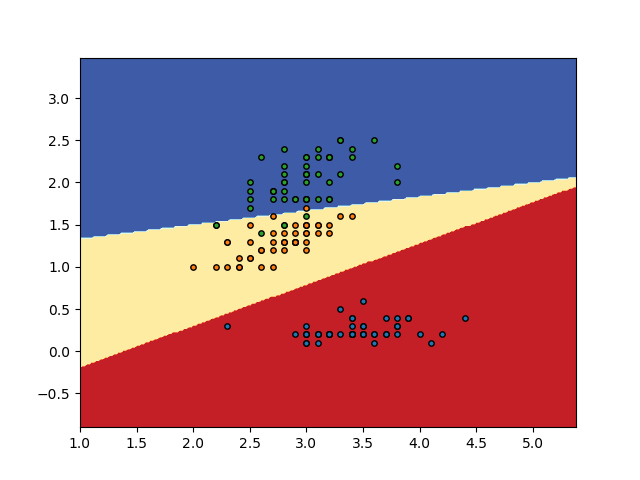

In [21]:
decision_boundary (X,y,model,iris)

Let's implement on vs One vs. All and One vs. One our self's.


## One vs. All (One-vs-Rest)


For one-vs-All classification, if we have K classes, we use K  two-class classifier models—the number of class labels present in the dataset is equal to the number of generated classifiers. First, we create an artificial class we will call this "dummy" class. For each classifier, we split the data into two classes.  We take the class samples we would like to classify; the rest of the samples will be labelled as a dummy class. We repeat the process for each class. To make a  classification, we use the classifier with the highest probability, disregarding the dummy class.


### Train Each Classifier


Here we train three classifiers and place them in the list <code>my_models</code>. For each class we take the class samples we would like to classify, and the rest will be labelled as a dummy class. We repeat the process for each class. For each classifier, we plot the decision regions. The class we are interested in is in red, and the dummy class is in blue. Similarly, the class samples are marked in blue, and the dummy samples are marked with a black x.


{0, 1, 2}


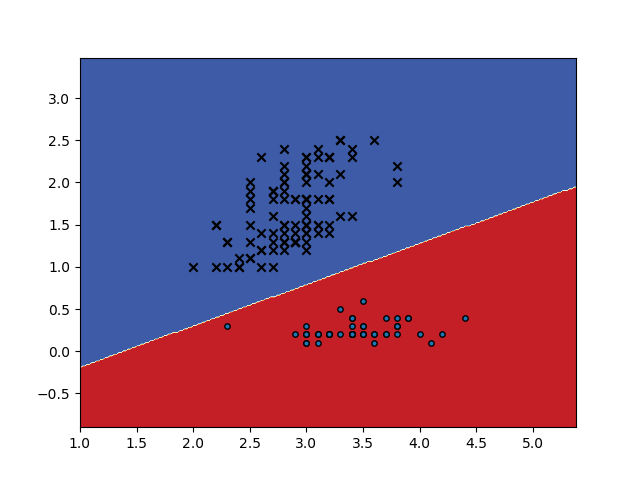

{0, 1, 2}


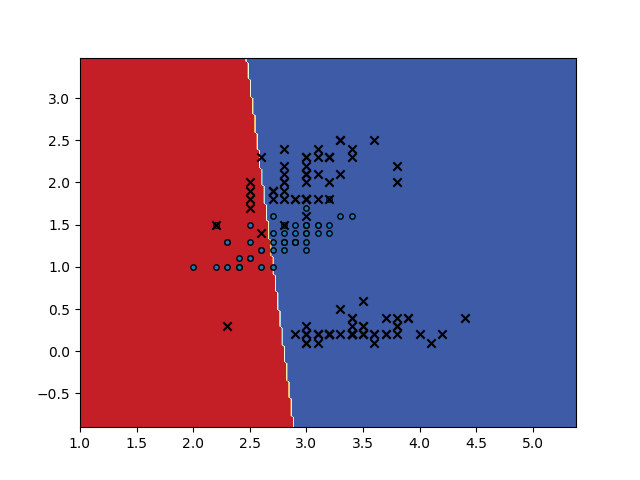

{0, 1, 2}


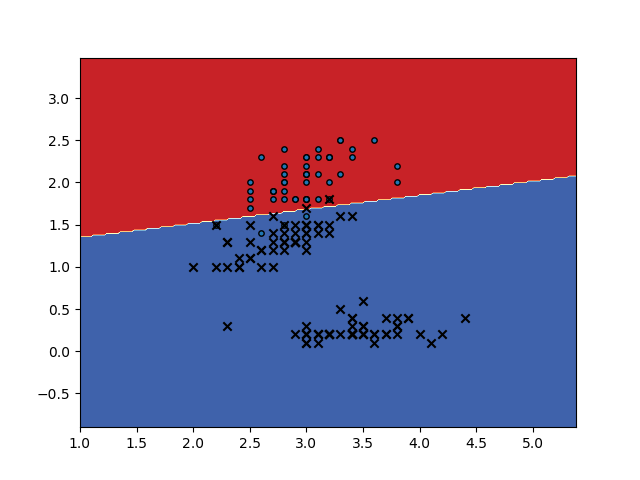

In [22]:
#dummy class
dummy_class=y.max()+1
#list used for classifiers 
my_models=[]
#iterate through each class
for class_ in np.unique(y):
    #select the index of our  class
    select=(y==class_)
    temp_y=np.zeros(y.shape)
    #class, we are trying to classify 
    temp_y[y==class_]=class_
    #set other samples  to a dummy class 
    temp_y[y!=class_]=dummy_class
    #Train model and add to list 
    model=SVC(kernel='linear', gamma=.5, probability=True)    
    my_models.append(model.fit(X,temp_y))
    #plot decision boundary 
    decision_boundary (X,temp_y,model,iris)


For each sample we calculate the  probability of belonging to each class, not including the dummy class.


In [23]:
probability_array=np.zeros((X.shape[0],3))
for j,model in enumerate(my_models):

    real_class=np.where(np.array(model.classes_)!=3)[0]

    probability_array[:,j]=model.predict_proba(X)[:,real_class][:,0]

here is the probability of belonging to each class for the first sample.


In [24]:
probability_array[0,:]

array([9.90966897e-01, 1.24866627e-01, 8.98661348e-12])

As each is the probability of belonging to the actual class and not the dummy class is does not sum to one.


In [25]:
probability_array[0,:].sum()

1.1158335237532842

We can plot the probability of belonging to the class. The row number is the sample number.


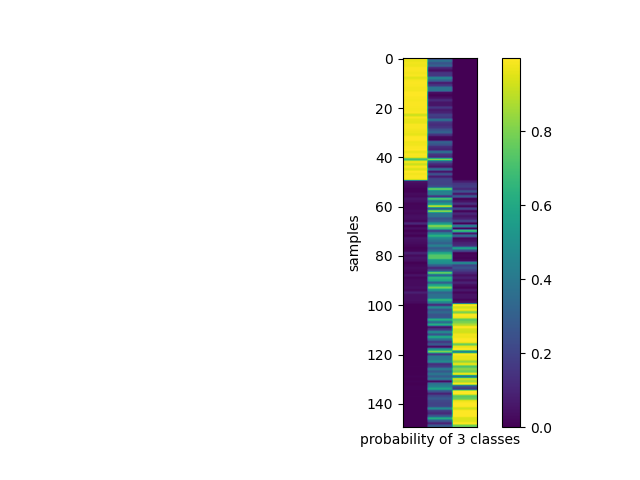

In [26]:
plot_probability_array(X,probability_array)

We can apply the $argmax$ function to each sample to find the class


In [27]:
one_vs_all=np.argmax(probability_array,axis=1)
one_vs_all

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

we can calculate the accuracy


In [28]:
accuracy_score(y,one_vs_all)

0.9466666666666667

We see the accuracy is less than the one obtained by sklearn, and this is because for SVM sklearn uses one vs one; let's verify it by comparing the outputs.


In [29]:
accuracy_score(one_vs_all,yhat)

0.9733333333333334

we see that the output are different, now lets implement one vs one


## One vs One


In One-vs-One classification, we split up the data into each class; we then train a two-class classifier on each pair of classes. For example, if we have class 0,1,2, we would train one classifier on the samples that are class 0 and class 1,  a second classifier on samples that are of class 0 and class 2 and a final classifier on samples of class 1 and class 2.

For  $K$ classes, we have to train  $K(K-1)/2$  classifiers. So if $K=3$, we have $(3x2)/2=3 $classes.

To perform classification on a sample, we perform a majority vote and select the class with the most predictions.


here we list each class.


In [ ]:
classes_=set(np.unique(y))
classes_
   

determine the number of classifiers:


In [ ]:
K=len(classes_)
K*(K-1)/2

We then train a two-class classifier on each pair of classes. We plot the different training points for each of the two classes


In [ ]:
pairs=[]
left_overs=classes_.copy()
#list used for classifiers 
my_models=[]
#iterate through each class
for class_ in classes_:
    #remove class we have seen before 
    left_overs.remove(class_)
    #the second class in the pair
    for second_class in left_overs:
        pairs.append(str(class_)+' and '+str(second_class))
        print("class {} vs class {} ".format(class_,second_class) )
        temp_y=np.zeros(y.shape)
        #find classes in pair 
        select=np.logical_or(y==class_ , y==second_class)
        #train model 
        model=SVC(kernel='linear', gamma=.5, probability=True)  
        model.fit(X[select,:],y[select])
        my_models.append(model)
        #Plot decision boundary for each pair and corresponding Training samples. 
        decision_boundary (X[select,:],y[select],model,iris,two=True)
   
        
    

In [ ]:
pairs

As we can see, our data is left-skewed, containing greater number of '5' star reviews.


Here, we are plotting the distribution of text length.


In [ ]:
pairs
majority_vote_array=np.zeros((X.shape[0],3))
majority_vote_dict={}
for j,(model,pair) in enumerate(zip(my_models,pairs)):

    majority_vote_dict[pair]=model.predict(X)
    majority_vote_array[:,j]=model.predict(X)

In the following table, each column is the output of a classifier for each  pair of classes; the output is the prediction:


In [ ]:
pd.DataFrame(majority_vote_dict).head(10)

To perform classification on a sample, we perform a majority vote i.e. select the class with the most predictions. We repeat the process for each sample.


In [ ]:
one_vs_one=np.array([np.bincount(sample.astype(int)).argmax() for sample  in majority_vote_array]) 
one_vs_one
    

We calculate the accuracy:


In [ ]:
accuracy_score(y,one_vs_one)

we compare it to sklearn , it's the same!


In [ ]:
accuracy_score(yhat,one_vs_one)

***


## Author


Joseph Santarcangelo


### Other Contributors


Azim Hirjani


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2020-07-20        | 0.2     | Azim       | Modified Multiple Areas |
| 2020-07-17        | 0.1     | Azim       | Created Lab Template    |


Copyright © 2020 IBM Corporation. All rights reserved.
